# Monte Carlo Value at Risk (VaR) — Notebook

This notebook is a self-contained, math-first exposition and implementation of Monte Carlo methods for Value at Risk (VaR) and Expected Shortfall (ES). It is written for a second-year Master student in mathematics and explains the probabilistic foundations, modelling choices, and practical implementation details.

## Roadmap
- Define VaR and ES precisely.
- Describe Monte Carlo estimation strategy and modelling choices (e.g., geometric Brownian motion, multivariate normal returns).
- Show algorithms and code to simulate returns and compute VaR and ES.
- Examples: single asset and small portfolio.
- Discuss error, convergence, and confidence intervals (bootstrap).

## 1. Definitions (math)

Let $L$ denote the loss of a portfolio over a fixed time horizon (e.g., 1 day, 10 days). We define the Value at Risk at level $lphan(0,1)$ as the $lpha$-quantile of the loss distribution: 

$$athrm{VaR}_{lpha}(L)=nfx:P(Le x)elpha=F_L^{-1}(lpha),$$
where $F_L$ is the cumulative distribution function of $L$. Intuitively, with probability $lpha$ the loss will not exceed $athrm{VaR}_{lpha}$.

Expected Shortfall (a.k.a. Conditional VaR) at level $lpha$ is the conditional expectation of losses beyond the VaR: 

$$athrm{ES}_{lpha}(L)=E[Lid L>athrm{VaR}_{lpha}(L)].$$

ES is a coherent risk measure and is often preferred because it reflects tail severity, not just a quantile.

## 2. Monte Carlo estimation idea

We simulate many independent sample losses $L_1,ots,L_N$ from a model for the portfolio over the time horizon, and estimate VaR by the empirical quantile: if $L_{(1)}eotse L_{(N)}$ are the order statistics then:

$$idehat{athrm{VaR}}_{lpha}=L_{(ceil lpha N
ceil)}.$$

For ES we use the empirical mean of the tail: 
$$idehat{athrm{ES}}_{lpha}=rac{1}{N-ceillpha N
ceil}
        um_{i=ceillpha N
ceil+1}^N L_{(i)}.$$

Statistical properties: by the Glivenko–Cantelli theorem and classical results on sample quantiles, these estimators converge as $N	onfty$; the Monte Carlo error scales roughly as $1/qrt{N}$ for smooth functionals and as $1/qrt{Nlpha(1-lpha)}$ for quantiles.

## 3. Modelling portfolio returns

We must choose a stochastic model for asset returns over the horizon. Common choices: 
- Log returns ~ normal (geometric Brownian motion for prices).
- Simple returns ~ multivariate normal for short horizons.

Geometric Brownian motion (GBM) for a single asset price $S_t$ is given by the SDE:
$$dS_t=u S_tdt+igma S_tdW_t,$$
with explicit solution over horizon $elta t$: 
$$S_{t+elta t}=S_txpeft((u-	frac{1}{2}igma^2)elta t+igmaqrt{elta t}Z
ight),uad Zim N(0,1).$$
Hence log-returns are normal. For multi-asset portfolios we can model the vector of log-returns as multivariate normal with a covariance matrix estimated from data.

## 4. Algorithm (high-level)
1. Choose horizon and model for returns (GBM or multivariate normal).
2. Calibrate parameters (drift, volatility, covariance).
3. Simulate N scenarios of returns (or asset prices).
4. Compute portfolio loss in each scenario (loss = -portfolio P&L).
5. Estimate VaR and ES from empirical distribution and, optionally, compute bootstrap confidence intervals.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

sns.set(style="darkgrid")
np.random.seed(42)

### Utility functions: simulate GBM and compute VaR/ES
The following functions implement simulation of log-returns (GBM) and empirical estimators. Explanations follow in comments.

In [2]:
def simulate_gbm_returns(S0, mu, sigma, horizon, n_scenarios, dt=1.0):
    """Simulate log-returns over a single horizon using GBM model.
    Returns array of price changes (P&L = S1 - S0) and log-returns.
    """
    # For a single-step horizon: log-return ~ N((mu-0.5*sigma^2)*dt, sigma*sqrt(dt))
    drift = (mu - 0.5 * sigma ** 2) * dt
    vol = sigma * np.sqrt(dt)
    Z = np.random.normal(size=n_scenarios)
    logR = drift + vol * Z
    S1 = S0 * np.exp(logR)
    pnl = S1 - S0
    return pnl, logR

def empirical_var(losses, alpha=0.95):
    # losses: array-like of losses (positive = loss). VaR at level alpha is alpha-quantile
    losses = np.asarray(losses)
    return np.quantile(losses, alpha)

def empirical_es(losses, alpha=0.95):
    losses = np.asarray(losses)
    q = empirical_var(losses, alpha)
    tail = losses[losses >= q]
    if len(tail) == 0:
        return q
    return tail.mean()

## 5. Example — single asset (GBM)
We simulate the distribution of 1-day loss for a single stock using GBM and estimate VaR (99%) and ES (99%).

In [3]:
# Parameters
S0 = 100.0  # current price
mu = 0.05   # annual drift ~ 5%
sigma = 0.2 # annual volatility ~ 20%
dt = 1/252  # one trading day (approx)
N = 200_000 # Monte Carlo scenarios
alpha = 0.99

pnl, logR = simulate_gbm_returns(S0, mu, sigma, horizon=1, n_scenarios=N, dt=dt)
losses = -pnl  # loss positive when price drops
var_99 = empirical_var(losses, alpha=alpha)
es_99 = empirical_es(losses, alpha=alpha)
var_99, es_99

(np.float64(2.8739735386280754), np.float64(3.2871024436057756))

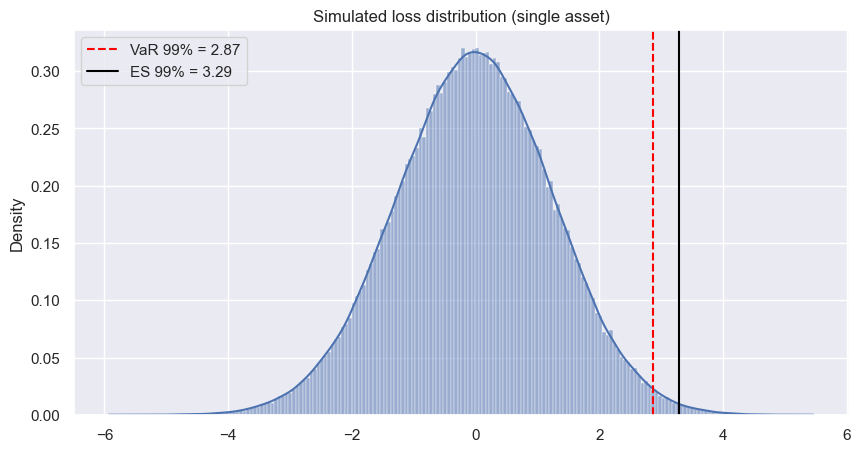

In [4]:
# Plot distribution and mark VaR
plt.figure(figsize=(10,5))
sns.histplot(losses, bins=200, kde=True, stat="density")
plt.axvline(var_99, color='red', linestyle='--', label=f'VaR {alpha*100:.0f}% = {var_99:.2f}')
plt.axvline(es_99, color='black', linestyle='-', label=f'ES {alpha*100:.0f}% = {es_99:.2f}')
plt.legend()
plt.title('Simulated loss distribution (single asset)')
plt.show()

## 6. Example — small portfolio (multivariate normal returns)
We simulate returns for a 3-asset portfolio using a multivariate normal model for log-returns. This lets us incorporate correlations.

In [5]:
def simulate_portfolio_losses(weights, S0s, mus, sigmas, corr, dt, N):
    """Simulate portfolio losses under multivariate normal log-returns.
    weights: portfolio weights (fractions of capital invested in each asset)
    S0s: initial prices array
    mus, sigmas: arrays of drift and volatility (annual)
    corr: correlation matrix
    dt: time horizon in years (e.g., 1/252)
    N: number of scenarios
    Returns array of portfolio losses.
    """
    n = len(S0s)
    cov = np.outer(sigmas, sigmas) * corr * dt
    mean = (mus - 0.5 * sigmas**2) * dt
    L = np.linalg.cholesky(cov)
    Z = np.random.normal(size=(N, n))
    correlated = Z @ L.T + mean
    S1 = S0s * np.exp(correlated)
    pnls = (S1 - S0s) * weights  # elementwise then sum
    portfolio_pnl = pnls.sum(axis=1)
    losses = -portfolio_pnl
    return losses

# Small portfolio example
weights = np.array([0.4, 0.3, 0.3])
S0s = np.array([100.0, 50.0, 80.0])
mus = np.array([0.05, 0.03, 0.06])
sigmas = np.array([0.18, 0.25, 0.22])
corr = np.array([[1.0, 0.6, 0.3],[0.6,1.0,0.2],[0.3,0.2,1.0]])
losses_port = simulate_portfolio_losses(weights, S0s, mus, sigmas, corr, dt, N=200_000)
var_p = empirical_var(losses_port, alpha=0.99)
es_p = empirical_es(losses_port, alpha=0.99)
var_p, es_p

(np.float64(1.80855631880013), np.float64(2.079010954245114))

## 7. Bootstrap confidence intervals for VaR
We can obtain a non-parametric confidence interval for the estimated VaR by bootstrap: resample the simulated losses (with replacement), compute the VaR on each resample, and take empirical quantiles of these VaR estimates. Note: this measures Monte Carlo sampling error, not model risk.

In [6]:
def bootstrap_var_ci(losses, alpha=0.99, B=1000, ci=0.95):
    n = len(losses)
    var_boot = np.empty(B)
    for b in range(B):
        sample = np.random.choice(losses, size=n, replace=True)
        var_boot[b] = np.quantile(sample, alpha)
    lower = np.quantile(var_boot, (1-ci)/2)
    upper = np.quantile(var_boot, 1-(1-ci)/2)
    return (lower, upper), var_boot

ci, var_boot = bootstrap_var_ci(losses_port, alpha=0.99, B=500)
ci

(np.float64(1.7980804745061123), np.float64(1.8213514480098467))

## 8. Discussion and further reading
- Monte Carlo VaR captures model-based tail behaviour but depends critically on the model (e.g., normal tails underestimate extreme events).
- Use heavy-tailed models or historical simulation when appropriate.
- Consider variance reduction (importance sampling) for rare-event estimation.

### References
- P. Glasserman, Monte Carlo Methods in Financial Engineering.
- J.-P. Bouchaud, M. Potters, Theory of Financial Risk and Derivative Pricing.